**Оглавление:**<a id='toc0_'></a>    
- [Расчёт юнит экономики привлечения клиентов из разных каналов](#toc1_)    
  - [Цель](#toc1_1_)    
  - [Задачи](#toc1_2_)    
  - [Описание](#toc1_3_)    
  - [План](#toc1_4_)    
- [Обзор данных](#toc2_)    
    - [Обзор таблиц](#toc2_1_1_)    
    - [Общая информация о таблицах](#toc2_1_2_)    
- [Предобработка данных](#toc3_)    
    - [Проверка числовых значений](#toc3_1_1_)    
    - [Проверка на дубликаты](#toc3_1_2_)    
- [Расчёты](#toc4_)    
    - [Построение графика распределения LTV пользователей по каналам привлечения](#toc4_1_1_)    
    - [Создание сводной таблицы по каналам привлечения клиентов](#toc4_1_2_)    
    - [Объединение таблицы затрат и сводной таблицы](#toc4_1_3_)    
    - [Расчёт метрики CAC](#toc4_1_4_)    
    - [Расчёт прибыли на один юнит для каналов привлечения](#toc4_1_5_)    
    - [Построение графика прибыли на одного юнита по каналам привлечения](#toc4_1_6_)    
- [Результаты](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Расчёт юнит экономики привлечения клиентов из разных каналов](#toc0_)

## <a id='toc1_1_'></a>[Цель](#toc0_)
Произвести рассчёты эффективности вложения средств в разные каналы привлечения клиентов.

## <a id='toc1_2_'></a>[Задачи](#toc0_)
1. Определить какие каналы окупаются;
2. Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит;
3. Сформулировать бизнес выводы на основании данных расчётов.

## <a id='toc1_3_'></a>[Описание](#toc0_)
Данные о LTV пользователей и стоимости привлечения находятся в файлах `customers.csv` и `cost_attraction.csv`. Перед выполнением расчётов необходимо произвести обзор данных. В предобработке данных будет произведена проверка на наличие ошибок в данных и при их наличии оценка их влияния на рассчёты. После этого будут осуществлены расчёты и формирование бизнес выводов.

В файле `customers.csv` содержится статистика по клиентам, привлеченным из каналов.
Поля:
- id клиента - номер клиента;
- Канал привлечения - канал из которого пришел клиент;
- LTV клиента, руб. - сколько прибыли принёс клиент за всё время взаимодействия с компанией.

В файле `cost_attraction.csv` содержится информация о общей стоимости привлечения для каждого канала.
Поля:
- Канал привлечения - канал, на который выполнены расходы на привлечение;
- Стоимость привлечения, руб. - сколько всего было потрачено на привлечение в данном канале.

## <a id='toc1_4_'></a>[План](#toc0_)
1. Обзор данных
2. Предобработка данных
3. Расчёты
4. Результаты расчётов

# <a id='toc2_'></a>[Обзор данных](#toc0_)
Проведём обзор данных с целью лучше понять их структуру

### <a id='toc2_1_1_'></a>[Обзор таблиц](#toc0_)
Импортируем необходимые библиотеки и считаем данные из файлов в dataframe (далее df)

In [144]:
import pandas as pd

# сохраняем в df данные по LTV пользователей
df_customers = pd.read_csv('data/customers.csv', sep = ';')

# сохраняем в df данные по затратам на привлечение в каждом канале
df_cost_attr = pd.read_csv('data/cost_attraction.csv', sep = ';')

Обзор данных по пользователям из таблицы `customers.csv`

In [145]:
# покажем первые 5 пользователей
df_customers.head()

,id клиента,Канал привлечения,"LTV, руб."
0,1,Реклама у блогеров,350
1,2,Реклама у блогеров,205
2,3,Реклама у блогеров,252
3,4,Таргетная реклама,531
4,5,Реклама у блогеров,325


Обзор данных по стоимости привлечения в каналах из таблицы `cost_attraction.csv`

In [146]:
# покажем данные по стоимости привлечения
df_cost_attr

,Канал привлечения,"Стоимость привлечения, руб."
0,Таргетная реклама,100000
1,e-mail рассылки,25000
2,Реклама у блогеров,120000
3,Контекстная реклама,90000
4,Нативная реклама,70000
5,Реклама в новостных СМИ,60000


### <a id='toc2_1_2_'></a>[Общая информация о таблицах](#toc0_)

In [147]:
# информация о таблице `customers.csv`
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id клиента         1801 non-null   int64 
 1   Канал привлечения  1801 non-null   object
 2   LTV, руб.          1801 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 42.3+ KB


В таблице `customers.csv` пропусков данных нет и поля с подходящими типами данных.

In [148]:
# информация о таблице `cost_attraction.csv`
df_cost_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Канал привлечения            6 non-null      object
 1   Стоимость привлечения, руб.  6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


В таблице `cost_attraction.csv` пропусков данных нет и поля с подходящими типами данных.

Мы выполнили обзор данных, который показал что в таблицах `customers.csv` и `cost_attraction.csv`:
- пропусков данных нет
- данные в полях в подходящих типах

# <a id='toc3_'></a>[Предобработка данных](#toc0_)
Выполним предобработку данных с целью подготовки их к расчётам

### <a id='toc3_1_1_'></a>[Проверка числовых значений](#toc0_)
Выполним проверку числовых значений в таблице `customers.csv` в поле `LTV, руб.` с целью исключения ошибок в данных. Отсортируем значения, так как при сортировке показываются ошибки в данных.

In [149]:
# отсортируем значения в df по полю `LTV, руб.` по возростанию
df_sorted = df_customers.sort_values(by='LTV, руб.', ascending=True)

# первые 5 элементов
df_sorted.head()

,id клиента,Канал привлечения,"LTV, руб."
1800,1801,Таргетная реклама,-100000
504,505,Реклама у блогеров,70
225,226,Реклама у блогеров,70
1787,1788,Реклама у блогеров,71
421,422,Реклама у блогеров,71


Мы видим, что в строке с минимальным значением `LTV, руб.` равно `-100000` - это ошибка в данных, удалим данную строку. 

In [150]:
# последние 5 элементов
df_sorted.tail()

,id клиента,Канал привлечения,"LTV, руб."
557,558,Контекстная реклама,788
1747,1748,Контекстная реклама,789
1002,1003,Контекстная реклама,794
552,553,Контекстная реклама,800
703,704,Контекстная реклама,802


С максимальным значением LTV ошибок не выявлено.

Устраним ошибку с минимальным значением LTV путём удаления строки с ошибкой.

In [151]:
# пересохраним в df с данными по клиентам все строки, кроме строки с ошибочным значением
df_customers = df_customers[df_customers['LTV, руб.'] != -100000]

# выполним повторную сортировку для проверки
df_customers = df_customers.sort_values(by='LTV, руб.', ascending=True)

# выведем повторно для проверки удаления ошибочного значения
df_customers.head()

,id клиента,Канал привлечения,"LTV, руб."
504,505,Реклама у блогеров,70
225,226,Реклама у блогеров,70
986,987,Реклама у блогеров,71
1787,1788,Реклама у блогеров,71
421,422,Реклама у блогеров,71


Выполнили повторную проверку и убедились, что с минимальным значением LTV ошибка устранена.

### <a id='toc3_1_2_'></a>[Проверка на дубликаты](#toc0_)
Проверим на уникальность пользователей в поле `id клиента` таблицы `customers.csv`

In [152]:
# кол-во уникальных пользователей
df_customers['id клиента'].nunique()

1800

Все 1800 пользователей уникальные.

Проверим на уникальность названия каналов в поле `канал привлечения` таблицы `customers.csv`

In [153]:
# кол-во уникальных пользователей
df_customers['Канал привлечения'].nunique()

6

Выведем уникальные названия каналов

In [154]:
# уникальные значения в поле
df_customers['Канал привлечения'].unique()

array(['Реклама у блогеров', 'Реклама в новостных СМИ', 'e-mail рассылки',
       'Нативная реклама', 'Таргетная реклама', 'Контекстная реклама'],
      dtype=object)

Все названия каналов уникальные.

Мы выполнили предобработку данных, а именно:
- удалили из таблицы `customers.csv` одну строку с ошибочным значением LTV равным - 10000;
- убедились, что в таблице `customers.csv` все клиенты уникальные;
- убедились, что в таблице `customers.csv` всего 6 уникальных названий каналов привлечения.

# <a id='toc4_'></a>[Расчёты](#toc0_)

### <a id='toc4_1_1_'></a>[Построение графика распределения LTV пользователей по каналам привлечения](#toc0_)
Построим график распределения LTV пользователей по каналам привлечения с целью увидеть из каких каналов пользователи в среднем приносят больше или меньше LTV.

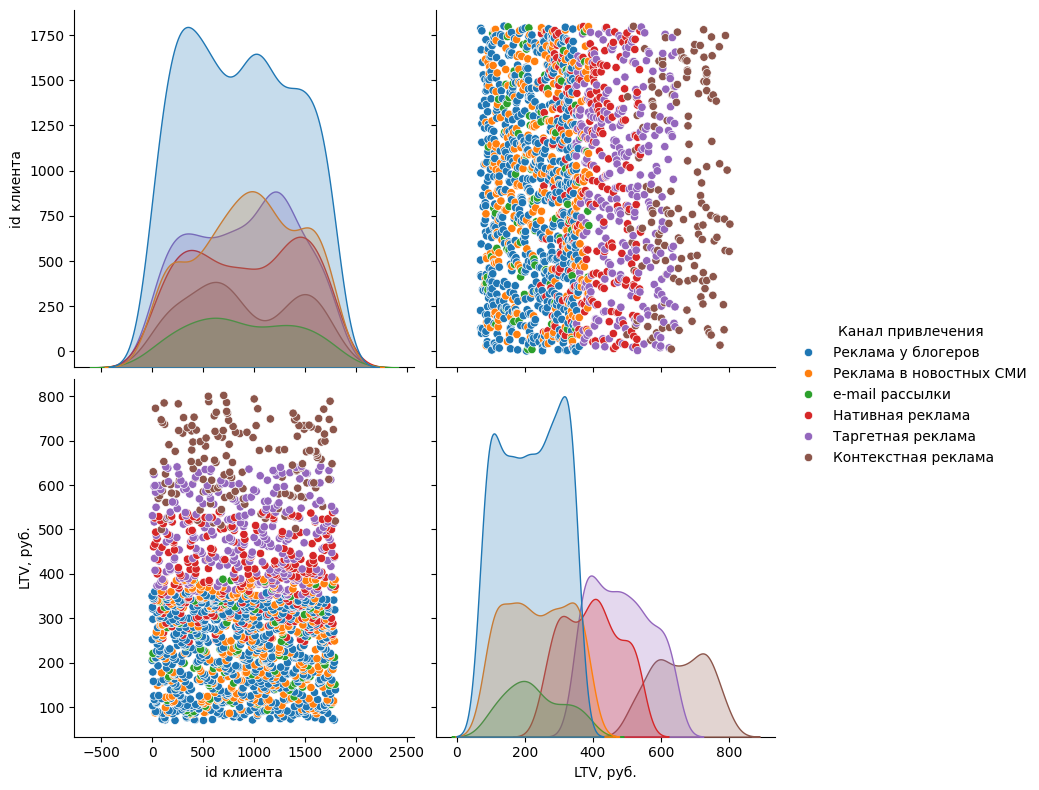

In [155]:
# импорт пакетов для графиков
from matplotlib import pyplot as plt
import seaborn as sns

# строим график распределения
sns.pairplot(df_customers, hue = 'Канал привлечения', height=4)
plt.show()

Из представленного графика мы видим, что например чётко прослеживается то, что каналы `Контекстная реклама` и `Таргетная реклама` приводят клиентов, у которых LTV в среднем выше, а например канал `Реклама у блогеров` приводит клиентов с меньшим LTV.

### <a id='toc4_1_2_'></a>[Создание сводной таблицы по каналам привлечения клиентов](#toc0_)
В сводную таблицу добавим два новых столбца:
1. Средний LTV на канал в руб.;
2. Кол-во клипентов, пришедших из канала.

In [158]:
# создаём сводную таблицу
df_agg = df_customers.groupby(['Канал привлечения',]).agg(
	mean = ('LTV, руб.', lambda x: round(x.mean(), 0)),  # Средний LTV на канал в руб. Подсчёт с округлением
	count = ('LTV, руб.', 'count'),                      # Кол-во клипентов, пришедших из канала. Подсчёт без округления
	).reset_index()

# переименовываем названия столбцов
df_agg.rename(columns={'mean': 'Средний LTV, руб.', 'count': 'Кол-во клиентов'}, inplace=True)
df_agg

,Канал привлечения,"Средний LTV, руб.",Кол-во клиентов
0,e-mail рассылки,229.0,96
1,Контекстная реклама,656.0,154
2,Нативная реклама,395.0,255
3,Реклама в новостных СМИ,236.0,312
4,Реклама у блогеров,217.0,671
5,Таргетная реклама,483.0,312


### <a id='toc4_1_3_'></a>[Объединение таблицы затрат и сводной таблицы](#toc0_)
Объединим таблицу затрат и сводную таблицу с целью увидеть общую картину.

In [159]:
# соединяем таблицы по полю `Канал привлечения`
df_group = pd.merge(df_cost_attr, df_agg, on='Канал привлечения', how='inner')
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов
0,Таргетная реклама,100000,483.0,312
1,e-mail рассылки,25000,229.0,96
2,Реклама у блогеров,120000,217.0,671
3,Контекстная реклама,90000,656.0,154
4,Нативная реклама,70000,395.0,255
5,Реклама в новостных СМИ,60000,236.0,312


### <a id='toc4_1_4_'></a>[Расчёт метрики CAC](#toc0_)
Расчитаем метрику CAC для каждого канала привлечения с целью узнать сколько приходится затрат в среднем на одного пользователя.

In [160]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов` с округлением
df_group = df_group.assign(cac = round(df_group['Стоимость привлечения, руб.'] / df_group['Кол-во клиентов'], 1))
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,cac
0,Таргетная реклама,100000,483.0,312,320.5
1,e-mail рассылки,25000,229.0,96,260.4
2,Реклама у блогеров,120000,217.0,671,178.8
3,Контекстная реклама,90000,656.0,154,584.4
4,Нативная реклама,70000,395.0,255,274.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3


### <a id='toc4_1_5_'></a>[Расчёт прибыли на один юнит для каналов привлечения](#toc0_)
Расчитаем для каждого канала среднюю прибыль на 1 пользователя через вычитание из среднего LTV и средних затрат на одного пользователя.

In [161]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов`
df_group = df_group.assign(ltv_cac = round(df_group['Средний LTV, руб.'] - df_group['cac'], 1))

# переименовываем названия столбцов
df_group.rename(columns={'cac': 'CAC, руб.', 'ltv_cac': 'Прибыль на 1 юнит, руб.'}, inplace=True)
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,"CAC, руб.","Прибыль на 1 юнит, руб."
0,Таргетная реклама,100000,483.0,312,320.5,162.5
1,e-mail рассылки,25000,229.0,96,260.4,-31.4
2,Реклама у блогеров,120000,217.0,671,178.8,38.2
3,Контекстная реклама,90000,656.0,154,584.4,71.6
4,Нативная реклама,70000,395.0,255,274.5,120.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3,43.7


### <a id='toc4_1_6_'></a>[Построение графика прибыли на одного юнита по каналам привлечения](#toc0_)
Для наглядности построим график и покажем на нём для каждого канала привлечения среднюю прибыль на одного пользователя.

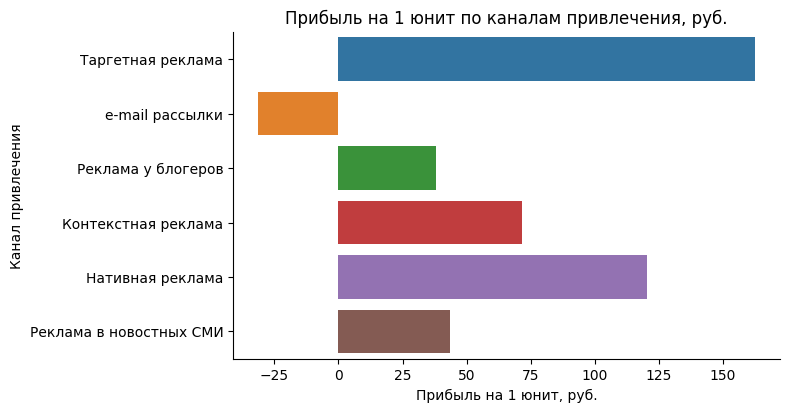

In [162]:
# построим график
sns.catplot(data=df_group, x="Прибыль на 1 юнит, руб.", y="Канал привлечения", kind="bar", orient="h",
            hue="Канал привлечения", height=4, aspect=2).set(title='Прибыль на 1 юнит по каналам привлечения, руб.')

Мы выполнили расчёты, а именно:
- в сводной таблице для каждого канала привлечения расчитали следующие показатели `Средний LTV, руб.` и `Кол-во клиентов`;
- объединили таблицу с общими затратами по каналам и сводную таблицу;
- расчитали метрику CAC;
- для каждого канала привлечения рассчитали прибыль на 1 юнит.

# <a id='toc5_'></a>[Результаты](#toc0_)
Вопрос 1: Определить какие каналы окупаются.
Ответ: Окупаются все каналы, кроме `e-mail рассылки`.

Вопрос 2: Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит.
Ответ: Самым прибыльным каналом является `Таргетная реклама`. 

Вопрос 3: Сформулировать бизнес выводы на основании данных расчётов.
Ответ: Канал `e-mail рассылки` приносит убытки и по этому, если у него нет прогнозов, что вскоре через этот канал будет приходить более платежеспособный клиент, то от него стоит отказаться. Канал `Таргетная реклама` самый выгодный с точки зрения прибыли на 1 клиента, поэтому инвестиции в него стоит увеличивать.